## Imports

In [1]:
import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import math

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN, KMeans, AgglomerativeClustering
import scipy.cluster.hierarchy as sch
from sklearn.metrics import silhouette_score
from kmodes.kmodes import KModes
from kmodes.kprototypes import KPrototypes

## Reading in Data

In [2]:
db = pd.read_csv("./datasets/cleaned.csv", )
db.head()

,complaint_number,status,date_entered,house_number,zip_code,house_street,special_district,complaint_category,unit,inspection_date,days_until_inspection,med_inc_zip
0,1245555,CLOSED,2009-01-02,930,10025,WEST END AVENUE,NOT SPECIAL,58,BOILR,2009-06-02,151,82352
1,1245608,CLOSED,2009-01-02,428,10013,BROADWAY,NOT SPECIAL,23,SCFLD,2009-10-09,280,106056
2,1245621,CLOSED,2009-01-02,146,10001,WEST 28 STREET,NOT SPECIAL,63,ELEVR,2009-01-22,20,85221
3,1245634,CLOSED,2009-01-03,388,10013,BROADWAY,NOT SPECIAL,56,BOILR,2009-01-07,4,106056
4,1245648,CLOSED,2009-01-03,375,10016,3 AVENUE,NOT SPECIAL,59,ELCTR,2009-01-08,5,109250


## Preprocessing

In [3]:
drop_cols = [
    "complaint_number",
    "days_until_inspection",
    "status",
    "house_number",
    "house_street",
]
X = db.drop(columns=drop_cols)

## Clustering

Since the dataset contains mostly categorical data and some numerical data as well, using a typical clustering algorithm like KMeans will not work. While we can one-hot encode the categorical columns, this does not give an effective range of numbers to base distances off of, so a more advanced method will be used, KPrototypes. This alogrithm splits the categorical and numerical data apart, and then applies KModes and KMeans, respectively, to the features to create the most appropriate clusters.

In [4]:
# refreshing on which columns are categorical
X.head()

,date_entered,zip_code,special_district,complaint_category,unit,inspection_date,med_inc_zip
0,2009-01-02,10025,NOT SPECIAL,58,BOILR,2009-06-02,82352
1,2009-01-02,10013,NOT SPECIAL,23,SCFLD,2009-10-09,106056
2,2009-01-02,10001,NOT SPECIAL,63,ELEVR,2009-01-22,85221
3,2009-01-03,10013,NOT SPECIAL,56,BOILR,2009-01-07,106056
4,2009-01-03,10016,NOT SPECIAL,59,ELCTR,2009-01-08,109250


## K-Modes Clustering

In [95]:
drop_cols = [
    "date_entered",
    "inspection_date",
    "med_inc_zip"
]

In [100]:
models = []
n_clusters = []
model_costs = []

for i in range(3, 21, 1):
    n_clusters.append(i)
    kmodes = KModes(n_clusters=i, n_init=10, random_state=42, n_jobs=-1, verbose=2)
    kmodes_model = kmodes.fit(X.drop(columns=drop_cols))
    model_costs.append(kmodes_model.cost_)
    

Initialization method and algorithm are deterministic. Setting n_init to 1.
Initialization method and algorithm are deterministic. Setting n_init to 1.
Initialization method and algorithm are deterministic. Setting n_init to 1.
Initialization method and algorithm are deterministic. Setting n_init to 1.
Initialization method and algorithm are deterministic. Setting n_init to 1.
Initialization method and algorithm are deterministic. Setting n_init to 1.
Initialization method and algorithm are deterministic. Setting n_init to 1.
Initialization method and algorithm are deterministic. Setting n_init to 1.
Initialization method and algorithm are deterministic. Setting n_init to 1.
Initialization method and algorithm are deterministic. Setting n_init to 1.
Initialization method and algorithm are deterministic. Setting n_init to 1.
Initialization method and algorithm are deterministic. Setting n_init to 1.
Initialization method and algorithm are deterministic. Setting n_init to 1.
Initializati

In [102]:
n_clusters

[3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

In [103]:
model_costs

[162922.0,
 153435.0,
 149255.0,
 142380.0,
 139884.0,
 135429.0,
 132455.0,
 130382.0,
 127277.0,
 124929.0,
 123458.0,
 122076.0,
 121418.0,
 121365.0,
 120550.0,
 119861.0,
 119742.0,
 119402.0]

In [113]:
model_costs[1] - model_costs[0]

-9487.0

In [117]:
model_diffs = [0]
for i, cost in enumerate(model_costs[1:]):
    print(i, cost)
    i_diff = cost - model_costs[i]
    model_diffs.append(i_diff)

0 153435.0
1 149255.0
2 142380.0
3 139884.0
4 135429.0
5 132455.0
6 130382.0
7 127277.0
8 124929.0
9 123458.0
10 122076.0
11 121418.0
12 121365.0
13 120550.0
14 119861.0
15 119742.0
16 119402.0


In [118]:
model_diffs

[0,
 -9487.0,
 -4180.0,
 -6875.0,
 -2496.0,
 -4455.0,
 -2974.0,
 -2073.0,
 -3105.0,
 -2348.0,
 -1471.0,
 -1382.0,
 -658.0,
 -53.0,
 -815.0,
 -689.0,
 -119.0,
 -340.0]

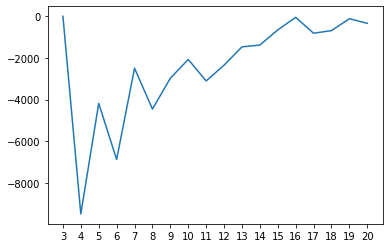

In [121]:
plt.plot(n_clusters, model_diffs)
plt.xticks(range(3, 21, 1));

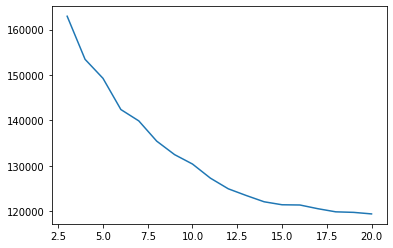

In [122]:
plt.plot(n_clusters, model_costs)

In [94]:
kmodes = KModes(n_clusters=11, n_init=10, random_state=42, n_jobs=-1, verbose=1)

Initialization method and algorithm are deterministic. Setting n_init to 1.


In [95]:
kmodes_model = kmodes.fit(X.drop(columns=drop_cols))

In [96]:
km_cost_4 = kmodes_model.cost_

In [97]:
kmodes_model.cluster_centroids_

array([['11419', 'NOT SPECIAL', '45', 'QNS.'],
       ['11221', 'NOT SPECIAL', '05', 'BKLYN'],
       ['10453', 'NOT SPECIAL', '63', 'ELEVR'],
       ['11211', 'NOT SPECIAL', '04', 'ERT  '],
       ['10014', 'NOT SPECIAL', '83', 'MAN.'],
       ['11235', 'NOT SPECIAL', '4B', 'SEP  '],
       ['10467', 'NOT SPECIAL', '31', 'BRONX'],
       ['10011', 'NOT SPECIAL', '59', 'ELCTR'],
       ['11216', 'NOT SPECIAL', '94', 'PLUMB'],
       ['11226', 'NOT SPECIAL', '4M', 'BEST '],
       ['11220', 'NOT SPECIAL', '23', 'SCFLD']], dtype='<U21')

In [70]:
kmodes_model.cost_

149255.0

In [93]:
km_cost_3

139884.0

In [98]:
km_cost_4

127277.0

## K-Prototypes Clustering

In [75]:
X.head()

,date_entered,zip_code,special_district,complaint_category,unit,inspection_date,med_inc_zip
0,2009-01-02,10025,NOT SPECIAL,58,BOILR,2009-06-02,82352
1,2009-01-02,10013,NOT SPECIAL,23,SCFLD,2009-10-09,106056
2,2009-01-02,10001,NOT SPECIAL,63,ELEVR,2009-01-22,85221
3,2009-01-03,10013,NOT SPECIAL,56,BOILR,2009-01-07,106056
4,2009-01-03,10016,NOT SPECIAL,59,ELCTR,2009-01-08,109250


In [76]:
X_kprot = X.drop(columns=["date_entered", "inspection_date"])

In [77]:
X_kprot.head()

,zip_code,special_district,complaint_category,unit,med_inc_zip
0,10025,NOT SPECIAL,58,BOILR,82352
1,10013,NOT SPECIAL,23,SCFLD,106056
2,10001,NOT SPECIAL,63,ELEVR,85221
3,10013,NOT SPECIAL,56,BOILR,106056
4,10016,NOT SPECIAL,59,ELCTR,109250


In [73]:
kprot = KPrototypes(n_clusters=5, n_jobs=-1, verbose=1, random_state=42)

In [79]:
kp_model = kprot.fit(X_kprot, categorical=[0, 1, 2, 3])

Best run was number 1


In [80]:
kp_model.cluster_centroids_

[array([[ 64501.11766558],
        [ 84571.7310049 ],
        [ 49592.29315229],
        [120111.74915825],
        [ 32845.14490952]]), array([['11419', 'NOT SPECIAL', '45', 'QNS.'],
        ['10025', 'NOT SPECIAL', '05', 'QNS.'],
        ['11221', 'NOT SPECIAL', '45', 'BKLYN'],
        ['11215', 'NOT SPECIAL', '05', 'MAN.'],
        ['11355', 'NOT SPECIAL', '63', 'ELEVR']], dtype='<U21')]

In [83]:
kp_model

array([1, 3, 1, ..., 0, 0, 1], dtype=uint16)

## Hierarchicial Analysis

In [54]:
X[["special_district", "complaint_category"]].to_numpy

<bound method DataFrame.to_numpy of       special_district complaint_category
0          NOT SPECIAL                 58
1          NOT SPECIAL                 23
2          NOT SPECIAL                 63
3          NOT SPECIAL                 56
4          NOT SPECIAL                 59
...                ...                ...
74335      NOT SPECIAL                 31
74336      NOT SPECIAL                 55
74337      NOT SPECIAL                 1Z
74338      NOT SPECIAL                 45
74339      NOT SPECIAL                 06

[74340 rows x 2 columns]>

In [57]:
pd.crosstab(X["zip_code"], X["complaint_category"], margins=True)

complaint_category,01,03,04,05,06,09,10,12,13,14,...,87,88,89,8A,90,91,92,93,94,All
zip_code,,,,,,,,,,,,,,,,,,,,,
10001,0,4,34,57,1,8,5,1,0,0,...,0,0,0,1,2,26,0,0,5,484
10002,0,1,31,142,1,11,9,4,0,2,...,0,2,0,0,0,14,1,0,14,656
10003,2,5,57,118,3,15,5,1,0,2,...,0,3,0,2,0,16,0,0,10,634
10004,0,0,7,9,0,1,3,0,0,0,...,0,0,0,0,0,0,0,0,2,59
10005,1,0,5,6,0,3,0,0,0,0,...,0,0,0,0,0,2,0,0,0,49
10006,0,0,7,8,0,3,4,1,0,0,...,0,1,0,0,0,4,0,0,1,70
10007,0,1,8,17,0,3,2,0,0,1,...,0,0,0,0,0,4,0,0,2,137
10009,0,0,25,116,1,10,11,1,0,1,...,0,0,0,0,0,20,0,0,5,528
10010,1,2,19,49,1,7,6,1,0,1,...,0,1,0,1,1,5,0,0,5,297


In [6]:
pd.crosstab()

ValueError: arrays must all be same length

In [5]:
dendrogram = sch.dendrogram(sch.linkage(X, method='ward'))

ValueError: could not convert string to float: '2009-01-02'

## K-Means

In [ ]:
KMeans()

## K-Prototypes

In [22]:
# trying kprotypes
kp = KPrototypes(n_clusters=5, random_state=42)

In [23]:
kp_model = kp.fit(X, categorical=[0,1,2,3,4,5])

In [ ]:
kp_model.